✅ Successfully connected to MT5
✅ Downloaded 30330 records for XAUUSD (1).

📊 Model Performance:
✅ Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
✅ Accuracy: 0.5035
              precision    recall  f1-score   support

           0       0.49      0.43      0.46      2982
           1       0.51      0.57      0.54      3082

    accuracy                           0.50      6064
   macro avg       0.50      0.50      0.50      6064
weighted avg       0.50      0.50      0.50      6064


📈 Trading Analysis:
📌 Strategy Return: 83.62%
💰 Final Balance: $9180.90 (Initial: $1000)
🔵 Net Profit: $4180.90


C:\Users\Admin\AppData\Local\Temp\ipykernel_15644\648668565.py:125: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['returns'].fillna(0, inplace=True)


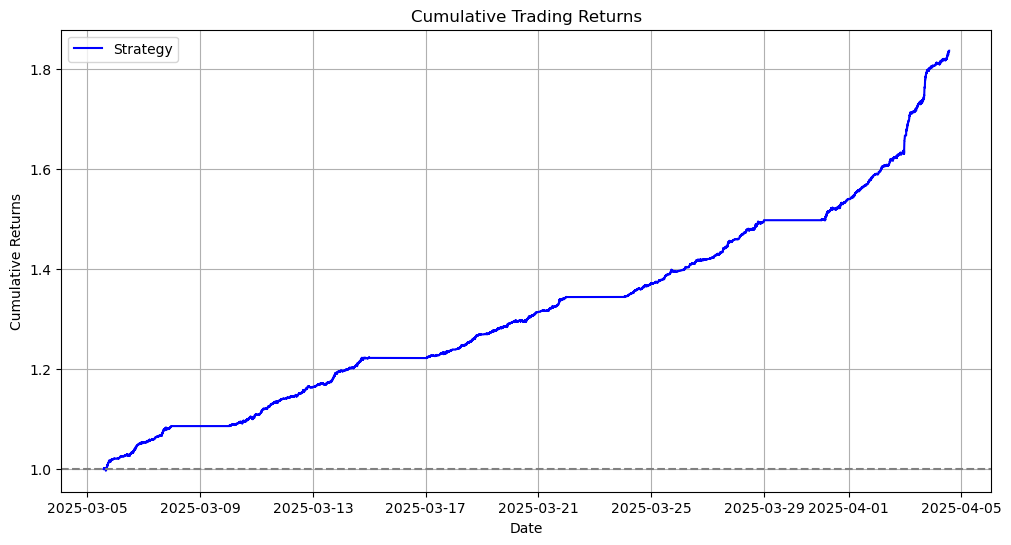


✅ **Recommendation: BUY** (Profitable Strategy)


In [1]:
import pandas as pd
import MetaTrader5 as mt5
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# ====================
# INITIALIZE MT5
# ====================
def initialize_mt5():
    if not mt5.initialize():
        print("❌ Failed to connect to MT5")
        mt5.shutdown()
        exit()
    print("✅ Successfully connected to MT5")

# ====================
# DATA COLLECTION
# ====================
SYMBOL = "XAUUSD"
TIMEFRAME = mt5.TIMEFRAME_M1
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=30)

def download_data(symbol, timeframe, start_date, end_date):
    """Fetch historical price data from MT5."""
    data = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    if data is None or len(data) == 0:
        print(f"⚠️ Warning: No data found for {symbol} ({timeframe}).")
        return None
    
    df = pd.DataFrame(data)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    print(f"✅ Downloaded {len(df)} records for {symbol} ({timeframe}).")
    return df

def calculate_indicators(df):
    """Calculate EMA, RSI, MACD, ATR, and Momentum."""
    df['ema50'] = df['close'].ewm(span=50, adjust=False).mean()
    df['ema100'] = df['close'].ewm(span=100, adjust=False).mean()
    df['rsi'] = calculate_rsi(df['close'])
    df['macd'] = df['close'].ewm(span=12).mean() - df['close'].ewm(span=26).mean()
    df['signal_line'] = df['macd'].ewm(span=9).mean()
    df['atr'] = calculate_atr(df)
    df['momentum'] = df['close'].diff(5)
    return df.dropna()

def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def calculate_atr(df, period=14):
    high_low = df['high'] - df['low']
    high_close = abs(df['high'] - df['close'].shift())
    low_close = abs(df['low'] - df['close'].shift())
    tr = high_low.combine(high_close, max).combine(low_close, max)
    return tr.rolling(period).mean()

# ====================
# DATA PREPARATION
# ====================
def prepare_data(df):
    """Prepare features and labels for machine learning."""
    df['future_close'] = df['close'].shift(-1)
    df['signal'] = np.where(df['future_close'] > df['close'], 1, 0)  # 1: Buy, 0: Sell
    features = ['ema50', 'ema100', 'rsi', 'macd', 'signal_line', 'atr', 'momentum']
    df.dropna(inplace=True)

    X = df[features]
    y = df['signal']
    
    return train_test_split(X, y, test_size=0.2, random_state=42)

# ====================
# MODEL TRAINING
# ====================
def train_model(X_train, X_test, y_train, y_test):
    """Train an XGBoost classifier with hyperparameter tuning."""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7]
    }
    
    model = xgb.XGBClassifier(eval_metric='logloss')
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    print("\n📊 Model Performance:")
    print(f"✅ Best Parameters: {grid_search.best_params_}")
    print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    
    return best_model, scaler

# ====================
# BACKTESTING & PROFIT/LOSS PREDICTION
# ====================
def backtest_trades(df, model, scaler):
    """Backtest the strategy and provide profit/loss prediction."""
    features = ['ema50', 'ema100', 'rsi', 'macd', 'signal_line', 'atr', 'momentum']
    X = df[features]
    X_scaled = scaler.transform(X)
    df['prediction'] = model.predict(X_scaled)
    
    # Calculate Returns
    df['returns'] = df['close'].pct_change().shift(-1) * df['prediction']
    df['returns'].fillna(0, inplace=True)
    
    # Simulate Trading (Starting Capital: $1000)
    initial_balance = 5000
    df['cumulative_returns'] = (1 + df['returns']).cumprod()
    final_balance = initial_balance * df['cumulative_returns'].iloc[-1]
    
    # Performance Analysis
    total_profit = final_balance - initial_balance
    total_return = (final_balance / initial_balance - 1) * 100
    
    print("\n📈 Trading Analysis:")
    print(f"📌 Strategy Return: {total_return:.2f}%")
    print(f"💰 Final Balance: ${final_balance:.2f} (Initial: $1000)")
    print(f"🔵 Net Profit: ${total_profit:.2f}")
    
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['cumulative_returns'], label='Strategy', color='blue')
    plt.axhline(y=1, color='gray', linestyle='dashed')
    plt.title('Cumulative Trading Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid()
    plt.show()
    
    if total_profit > 0:
        print("\n✅ **Recommendation: BUY** (Profitable Strategy)")
    else:
        print("\n❌ **Recommendation: SELL** (Unprofitable Strategy)")
    
    return df

# ====================
# MAIN EXECUTION
# ====================
if __name__ == "__main__":
    initialize_mt5()
    
    df = download_data(SYMBOL, TIMEFRAME, START_DATE, END_DATE)
    
    if df is not None:
        df = calculate_indicators(df)
        X_train, X_test, y_train, y_test = prepare_data(df)
        
        model, scaler = train_model(X_train, X_test, y_train, y_test)
        backtest_trades(df, model, scaler)
    else:
        print("\n❌ Error: Data download failed.")
    
    mt5.shutdown()


In [3]:
import pandas as pd
import MetaTrader5 as mt5
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from datetime import datetime, timedelta
import time

# ====================
# CONFIGURATION
# ====================
ACCOUNT = 52239674
PASSWORD = "wbRKYo5cX&TQt6"
SERVER = "ICMarketsSC-Demo"
SYMBOL = "EURJPY"
TIMEFRAME = mt5.TIMEFRAME_M1  # 1-minute data
LOT_SIZE = 0.1  # Trade size in lots
MODEL_TRAINING_PERIOD = 30  # Days of historical data
SLIPPAGE = 3  # Allowed slippage in points
RISK_PERCENT = 1.0  # Risk 1% of account per trade
MIN_CONFIDENCE = 0.50  # Minimum confidence to trade

# ====================
# MT5 CONNECTION
# ====================
def initialize_mt5():
    if not mt5.initialize():
        print("❌ Failed to initialize MT5")
        return False
    
    print("✅ MT5 initialized successfully")
    
    authorized = mt5.login(ACCOUNT, password=PASSWORD, server=SERVER)
    if not authorized:
        print(f"❌ Failed to connect to account #{ACCOUNT}")
        mt5.shutdown()
        return False
    
    account_info = mt5.account_info()
    print(f"✅ Connected to account #{ACCOUNT}")
    print(f"🔹 Balance: {account_info.balance}")
    print(f"🔹 Equity: {account_info.equity}")
    return True

# ====================
# DATA FUNCTIONS
# ====================
def download_data(symbol, timeframe, days):
    """Get historical price data"""
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    
    rates = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    if rates is None:
        print(f"⚠️ No data for {symbol}")
        return None
    
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    print(f"✅ Downloaded {len(df)} {symbol} records")
    return df

def calculate_indicators(df):
    """Calculate technical indicators"""
    # Moving Averages
    df['ema50'] = df['close'].ewm(span=50, adjust=False).mean()
    df['ema100'] = df['close'].ewm(span=100, adjust=False).mean()
    
    # Momentum
    df['rsi'] = calculate_rsi(df['close'])
    df['momentum'] = df['close'].diff(5)
    
    # MACD
    df['macd'] = df['close'].ewm(span=12).mean() - df['close'].ewm(span=26).mean()
    df['signal_line'] = df['macd'].ewm(span=9).mean()
    
    # Volatility
    df['atr'] = calculate_atr(df)
    
    return df.dropna()

def calculate_rsi(series, period=14):
    """Relative Strength Index"""
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def calculate_atr(df, period=14):
    """Average True Range"""
    high_low = df['high'] - df['low']
    high_close = abs(df['high'] - df['close'].shift())
    low_close = abs(df['low'] - df['close'].shift())
    tr = high_low.combine(high_close, max).combine(low_close, max)
    return tr.rolling(period).mean()

# ====================
# MODEL FUNCTIONS
# ====================
def prepare_data(df):
    """Prepare data for machine learning"""
    df['future_close'] = df['close'].shift(-1)
    df['signal'] = np.where(df['future_close'] > df['close'], 1, 0)
    
    features = ['ema50', 'ema100', 'rsi', 'macd', 'signal_line', 'atr', 'momentum']
    df.dropna(inplace=True)
    
    X = df[features]
    y = df['signal']
    return train_test_split(X, y, test_size=0.2, random_state=42)

def train_model(X_train, X_test, y_train, y_test):
    """Train XGBoost model"""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = xgb.XGBClassifier(eval_metric='logloss')
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7]
    }
    
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    print("\n📊 Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))
    
    return best_model, scaler

# ====================
# TRADING FUNCTIONS
# ====================
def get_current_data(symbol, timeframe, count=100):
    """Get recent market data"""
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, count)
    if rates is None:
        print(f"⚠️ No current data for {symbol}")
        return None
    
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    return df

def execute_trade(symbol, trade_type, lot_size, slippage):
    """Execute buy/sell order"""
    symbol_info = mt5.symbol_info(symbol)
    if not symbol_info:
        print(f"❌ {symbol} not found")
        return False
    
    if not symbol_info.visible:
        mt5.symbol_select(symbol, True)
    
    point = symbol_info.point
    price = mt5.symbol_info_tick(symbol).ask if trade_type == 'buy' else mt5.symbol_info_tick(symbol).bid
    
    # Risk management - 20 pip SL, 40 pip TP
    sl_price = price - (20 * point) if trade_type == 'buy' else price + (20 * point)
    tp_price = price + (40 * point) if trade_type == 'buy' else price - (40 * point)
    
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": lot_size,
        "type": mt5.ORDER_TYPE_BUY if trade_type == 'buy' else mt5.ORDER_TYPE_SELL,
        "price": price,
        "sl": sl_price,
        "tp": tp_price,
        "deviation": slippage,
        "magic": 123456,
        "comment": "XGBoost Bot",
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_IOC,
    }
    
    result = mt5.order_send(request)
    if result.retcode != mt5.TRADE_RETCODE_DONE:
        print(f"❌ Trade failed: {result.comment}")
        return False
    
    print(f"✅ {trade_type} {lot_size} lots at {price}")
    return True

def close_all_positions(symbol):
    """Close all open trades"""
    positions = mt5.positions_get(symbol=symbol)
    if not positions:
        return True
    
    for position in positions:
        trade_type = mt5.ORDER_TYPE_SELL if position.type == mt5.ORDER_TYPE_BUY else mt5.ORDER_TYPE_BUY
        price = mt5.symbol_info_tick(symbol).bid if trade_type == mt5.ORDER_TYPE_SELL else mt5.symbol_info_tick(symbol).ask
        
        request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": position.volume,
            "type": trade_type,
            "position": position.ticket,
            "price": price,
            "deviation": SLIPPAGE,
            "magic": 123456,
            "comment": "Closing trade",
            "type_time": mt5.ORDER_TIME_GTC,
            "type_filling": mt5.ORDER_FILLING_IOC,
        }
        
        result = mt5.order_send(request)
        if result.retcode != mt5.TRADE_RETCODE_DONE:
            print(f"❌ Failed to close position {position.ticket}")
            return False
    
    return True

# ====================
# MAIN TRADING LOOP
# ====================
def trading_loop():
    print("\n🚀 Starting Trading Bot...")
    
    # 1. Train initial model
    print("\n🔹 Training model...")
    df = download_data(SYMBOL, TIMEFRAME, MODEL_TRAINING_PERIOD)
    if df is None:
        return
    
    df = calculate_indicators(df)
    X_train, X_test, y_train, y_test = prepare_data(df)
    model, scaler = train_model(X_train, X_test, y_train, y_test)
    features = X_train.columns.tolist()
    
    # 2. Start trading
    print("\n🔹 Starting live trading...")
    last_trade_time = None
    trade_cooldown = timedelta(minutes=5)
    
    try:
        while True:
            now = datetime.now()
            print(f"\n⏰ {now.strftime('%H:%M:%S')} - Analyzing market...")
            
            # Get current data
            current_df = get_current_data(SYMBOL, TIMEFRAME, 200)
            if current_df is None:
                time.sleep(30)
                continue
            
            # Prepare for prediction
            current_df = calculate_indicators(current_df)
            X_current = current_df[features].iloc[-1:].values
            X_current_scaled = scaler.transform(X_current)
            
            # Make prediction
            prediction = model.predict(X_current)[0]
            confidence = max(model.predict_proba(X_current)[0])
            print(f"🔹 Prediction: {'BUY' if prediction == 1 else 'SELL'} ({confidence:.1%} confidence)")
            
            # Trade execution logic
            if confidence > MIN_CONFIDENCE:
                if last_trade_time is None or (now - last_trade_time) > trade_cooldown:
                    close_all_positions(SYMBOL)
                    trade_type = 'buy' if prediction == 1 else 'sell'
                    if execute_trade(SYMBOL, trade_type, LOT_SIZE, SLIPPAGE):
                        last_trade_time = now
                else:
                    next_trade = last_trade_time + trade_cooldown
                    print(f"⏳ Next trade at {next_trade.strftime('%H:%M')}")
            else:
                print(f"🔍 Low confidence ({confidence:.1%} < {MIN_CONFIDENCE:.0%})")
            
            time.sleep(10)
            
    except KeyboardInterrupt:
        print("\n🛑 Bot stopped by user")
    finally:
        print("\n🔹 Shutting down...")
        close_all_positions(SYMBOL)
        mt5.shutdown()

# ====================
# PROGRAM START
# ====================
if __name__ == "__main__":
    if initialize_mt5():
        trading_loop()
    else:
        print("❌ Failed to start bot")

✅ MT5 initialized successfully
✅ Connected to account #52239674
🔹 Balance: 405.25
🔹 Equity: 405.25

🚀 Starting Trading Bot...

🔹 Training model...
✅ Downloaded 31371 EURJPY records

📊 Model Performance:
Accuracy: 0.50
              precision    recall  f1-score   support

           0       0.50      0.85      0.63      3147
           1       0.49      0.14      0.22      3125

    accuracy                           0.50      6272
   macro avg       0.49      0.50      0.42      6272
weighted avg       0.49      0.50      0.43      6272


🔹 Starting live trading...

⏰ 09:27:44 - Analyzing market...
🔹 Prediction: SELL (51.4% confidence)
❌ Trade failed: Invalid stops


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



⏰ 09:27:54 - Analyzing market...
🔹 Prediction: SELL (51.4% confidence)
❌ Trade failed: Invalid stops


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🛑 Bot stopped by user

🔹 Shutting down...


In [ ]:
import pandas as pd
import MetaTrader5 as mt5
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

# ====================
# CONFIGURATION
# ====================
ACCOUNT = 52239674  
PASSWORD = "wbRKYo5cX&TQt6"  
SERVER = "ICMarketsSC-Demo" 
SYMBOL = "EURJPY"
TIMEFRAME = mt5.TIMEFRAME_M1  
LOT_SIZE = 0.1  
MODEL_TRAINING_PERIOD = 30 
SLIPPAGE = 3  

# ====================
# INITIALIZE MT5 CONNECTION/
# ====================
def initialize_mt5():
    if not mt5.initialize():
        print("❌ Failed to initialize MT5")
        return False
    
    print("✅ MT5 initialized successfully")
    
    # Attempt to login
    authorized = mt5.login(ACCOUNT, password=PASSWORD, server=SERVER)
    if not authorized:
        print(f"❌ Failed to connect to account #{ACCOUNT}: {mt5.last_error()}")
        mt5.shutdown()
        return False
    
    print(f"✅ Connected to account #{ACCOUNT}")
    print(f"🔹 Account balance: {mt5.account_info().balance}")
    return True

# ====================
# DATA COLLECTION
# ====================
def download_data(symbol, timeframe, days):
    """Fetch historical price data from MT5."""
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    
    rates = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    if rates is None or len(rates) == 0:
        print(f"⚠️ Warning: No data found for {symbol} ({timeframe}).")
        return None
    
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    print(f"✅ Downloaded {len(df)} records for {symbol} ({timeframe}).")
    return df

def calculate_indicators(df):
    """Calculate technical indicators."""
    df['ema50'] = df['close'].ewm(span=50, adjust=False).mean()
    df['ema100'] = df['close'].ewm(span=100, adjust=False).mean()
    df['rsi'] = calculate_rsi(df['close'])
    df['macd'] = df['close'].ewm(span=12).mean() - df['close'].ewm(span=26).mean()
    df['signal_line'] = df['macd'].ewm(span=9).mean()
    df['atr'] = calculate_atr(df)
    df['momentum'] = df['close'].diff(5)
    return df.dropna()

def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def calculate_atr(df, period=14):
    high_low = df['high'] - df['low']
    high_close = abs(df['high'] - df['close'].shift())
    low_close = abs(df['low'] - df['close'].shift())
    tr = high_low.combine(high_close, max).combine(low_close, max)
    return tr.rolling(period).mean()

# ====================
# DATA PREPARATION
# ====================
def prepare_data(df):
    """Prepare features and labels for machine learning."""
    df['future_close'] = df['close'].shift(-1)
    df['signal'] = np.where(df['future_close'] > df['close'], 1, 0)  # 1: Buy, 0: Sell
    features = ['ema50', 'ema100', 'rsi', 'macd', 'signal_line', 'atr', 'momentum']
    df.dropna(inplace=True)

    X = df[features]
    y = df['signal']
    
    return train_test_split(X, y, test_size=0.2, random_state=42)

# ====================
# MODEL TRAINING
# ====================
def train_model(X_train, X_test, y_train, y_test):
    """Train an XGBoost classifier with hyperparameter tuning."""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7]
    }
    
    model = xgb.XGBClassifier(eval_metric='logloss')
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    print("\n📊 Model Performance:")
    print(f"✅ Best Parameters: {grid_search.best_params_}")
    print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    
    return best_model, scaler

# ====================
# TRADING FUNCTIONS
# ====================
def get_current_data(symbol, timeframe, count=100):
    """Get the most recent price data."""
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, count)
    if rates is None or len(rates) == 0:
        print(f"⚠️ Warning: No current data found for {symbol} ({timeframe}).")
        return None
    
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    return df

def prepare_current_data(df, scaler, features):
    """Prepare current market data for prediction."""
    df = calculate_indicators(df.copy())
    X_current = df[features].iloc[-1:].values  # Get only the latest data point
    X_current_scaled = scaler.transform(X_current)
    return X_current_scaled

def execute_trade(symbol, trade_type, lot_size, slippage):
    """Execute a buy or sell order."""
    symbol_info = mt5.symbol_info(symbol)
    if symbol_info is None:
        print(f"❌ {symbol} not found")
        return False
    
    if not symbol_info.visible:
        print(f"❌ {symbol} is not visible, trying to switch on")
        mt5.symbol_select(symbol, True)
    
    point = mt5.symbol_info(symbol).point
    price = mt5.symbol_info_tick(symbol).ask if trade_type == 'buy' else mt5.symbol_info_tick(symbol).bid
    deviation = slippage
    
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": lot_size,
        "type": mt5.ORDER_TYPE_BUY if trade_type == 'buy' else mt5.ORDER_TYPE_SELL,
        "price": price,
        "sl": 0.0,
        "tp": 0.0,
        "deviation": deviation,
        "magic": 123456,
        "comment": "XGBoost bot trade",
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_IOC,
    }
    
    result = mt5.order_send(request)
    if result.retcode != mt5.TRADE_RETCODE_DONE:
        print(f"❌ Trade failed: {result.comment}")
        return False
    
    print(f"✅ Trade executed: {trade_type} {lot_size} lots of {symbol} at {price}")
    return True

def close_all_positions(symbol):
    """Close all open positions for the symbol."""
    positions = mt5.positions_get(symbol=symbol)
    if not positions:
        print(f"No open positions for {symbol}")
        return
    
    for position in positions:
        trade_type = mt5.ORDER_TYPE_SELL if position.type == mt5.ORDER_TYPE_BUY else mt5.ORDER_TYPE_BUY
        price = mt5.symbol_info_tick(symbol).bid if trade_type == mt5.ORDER_TYPE_SELL else mt5.symbol_info_tick(symbol).ask
        
        request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": position.volume,
            "type": trade_type,
            "position": position.ticket,
            "price": price,
            "deviation": SLIPPAGE,
            "magic": 123456,
            "comment": "Close position",
            "type_time": mt5.ORDER_TIME_GTC,
            "type_filling": mt5.ORDER_FILLING_IOC,
        }
        
        result = mt5.order_send(request)
        if result.retcode != mt5.TRADE_RETCODE_DONE:
            print(f"Failed to close position {position.ticket}: {result.comment}")
        else:
            print(f"✅ Closed position {position.ticket}")

# ====================
# MAIN TRADING LOOP
# ====================
def trading_loop():
    print("\nStarting trading bot...")
    
    # Initial model training
    print("\n🔹 Training initial model...")
    df = download_data(SYMBOL, TIMEFRAME, MODEL_TRAINING_PERIOD)
    if df is None:
        print("❌ Error: Initial data download failed.")
        return
    
    df = calculate_indicators(df)
    X_train, X_test, y_train, y_test = prepare_data(df)
    model, scaler = train_model(X_train, X_test, y_train, y_test)
    features = ['ema50', 'ema100', 'rsi', 'macd', 'signal_line', 'atr', 'momentum']
    
    last_trade_time = None
    trade_cooldown = timedelta(minutes=1)  # Wait at least 1 minute between trades
    
    try:
        while True:
            now = datetime.now()
            print(f"\n🔹 Checking market at {now.strftime('%Y-%m-%d %H:%M:%S')}")
            
            # Get current market data
            current_df = get_current_data(SYMBOL, TIMEFRAME, count=200)
            if current_df is None:
                print("❌ Error getting current data. Retrying in 30 seconds...")
                time.sleep(30)
                continue
            
            # Prepare data for prediction
            X_current = prepare_current_data(current_df, scaler, features)
            if X_current is None:
                print("❌ Error preparing current data. Retrying in 30 seconds...")
                time.sleep(30)
                continue
            
            # Make prediction
            prediction = model.predict(X_current)[0]
            prediction_proba = model.predict_proba(X_current)[0]
            confidence = max(prediction_proba)
            
            print(f"🔹 Prediction: {'BUY' if prediction == 1 else 'SELL'} (Confidence: {confidence:.2%})")
            
            # Check if we should trade based on confidence and cooldown
            if confidence > 0.50:  # Only trade if confidence > 65%
                if last_trade_time is None or (now - last_trade_time) > trade_cooldown:
                    # Close any existing positions first
                    close_all_positions(SYMBOL)
                    
                    # Execute new trade
                    trade_type = 'buy' if prediction == 1 else 'sell'
                    if execute_trade(SYMBOL, trade_type, LOT_SIZE, SLIPPAGE):
                        last_trade_time = now
                    else:
                        print("❌ Trade execution failed. Waiting before retrying...")
                        time.sleep(60)
                else:
                    print(f"⏳ Waiting for trade cooldown (next trade available at {(last_trade_time + trade_cooldown).strftime('%H:%M:%S')})")
            else:
                print("🔍 Confidence too low - no trade executed")
            
            # Wait before next check
            time.sleep(10)
            
    except KeyboardInterrupt:
        print("\n🛑 Bot stopped by user")
    finally:
        print("\n🔹 Closing all positions and shutting down...")
        close_all_positions(SYMBOL)
        mt5.shutdown()

# ====================
# MAIN EXECUTION
# ====================
if __name__ == "__main__":
    if initialize_mt5():
        trading_loop()
    else:
        print("❌ Failed to initialize trading bot")

✅ MT5 initialized successfully
✅ Connected to account #52239674
🔹 Account balance: 355.39

Starting trading bot...

🔹 Training initial model...
✅ Downloaded 31636 records for EURJPY (1).

📊 Model Performance:
✅ Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
✅ Accuracy: 0.5119
              precision    recall  f1-score   support

           0       0.51      0.61      0.56      3158
           1       0.52      0.41      0.46      3167

    accuracy                           0.51      6325
   macro avg       0.51      0.51      0.51      6325
weighted avg       0.51      0.51      0.51      6325


🔹 Checking market at 2025-04-11 15:22:21
🔹 Prediction: SELL (Confidence: 53.07%)
No open positions for EURJPY


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ Trade executed: sell 0.1 lots of EURJPY at 162.367

🔹 Checking market at 2025-04-11 15:22:32
🔹 Prediction: SELL (Confidence: 52.77%)
⏳ Waiting for trade cooldown (next trade available at 15:23:21)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:22:42
🔹 Prediction: SELL (Confidence: 52.77%)
⏳ Waiting for trade cooldown (next trade available at 15:23:21)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:22:52
🔹 Prediction: BUY (Confidence: 53.36%)
⏳ Waiting for trade cooldown (next trade available at 15:23:21)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:23:02
🔹 Prediction: SELL (Confidence: 55.66%)
⏳ Waiting for trade cooldown (next trade available at 15:23:21)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:23:12
🔹 Prediction: SELL (Confidence: 51.69%)
⏳ Waiting for trade cooldown (next trade available at 15:23:21)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:23:22
🔹 Prediction: BUY (Confidence: 50.49%)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ Closed position 995874675
✅ Trade executed: buy 0.1 lots of EURJPY at 162.259

🔹 Checking market at 2025-04-11 15:23:34
🔹 Prediction: BUY (Confidence: 52.10%)
⏳ Waiting for trade cooldown (next trade available at 15:24:22)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:23:44
🔹 Prediction: BUY (Confidence: 52.10%)
⏳ Waiting for trade cooldown (next trade available at 15:24:22)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:23:54
🔹 Prediction: BUY (Confidence: 52.10%)
⏳ Waiting for trade cooldown (next trade available at 15:24:22)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:24:04
🔹 Prediction: BUY (Confidence: 54.08%)
⏳ Waiting for trade cooldown (next trade available at 15:24:22)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:24:14
🔹 Prediction: BUY (Confidence: 54.08%)
⏳ Waiting for trade cooldown (next trade available at 15:24:22)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:24:24
🔹 Prediction: BUY (Confidence: 53.51%)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ Closed position 995875992
✅ Trade executed: buy 0.1 lots of EURJPY at 162.173

🔹 Checking market at 2025-04-11 15:24:36
🔹 Prediction: BUY (Confidence: 53.50%)
⏳ Waiting for trade cooldown (next trade available at 15:25:24)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:24:46
🔹 Prediction: BUY (Confidence: 53.50%)
⏳ Waiting for trade cooldown (next trade available at 15:25:24)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:24:57
🔹 Prediction: BUY (Confidence: 53.50%)
⏳ Waiting for trade cooldown (next trade available at 15:25:24)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:25:07
🔹 Prediction: BUY (Confidence: 50.12%)
⏳ Waiting for trade cooldown (next trade available at 15:25:24)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:25:17
🔹 Prediction: BUY (Confidence: 50.12%)
⏳ Waiting for trade cooldown (next trade available at 15:25:24)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:25:27
🔹 Prediction: BUY (Confidence: 50.12%)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ Closed position 995878665
✅ Trade executed: buy 0.1 lots of EURJPY at 162.142

🔹 Checking market at 2025-04-11 15:25:38
🔹 Prediction: SELL (Confidence: 56.20%)
⏳ Waiting for trade cooldown (next trade available at 15:26:27)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:25:48
🔹 Prediction: SELL (Confidence: 50.13%)
⏳ Waiting for trade cooldown (next trade available at 15:26:27)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:25:58
🔹 Prediction: BUY (Confidence: 50.12%)
⏳ Waiting for trade cooldown (next trade available at 15:26:27)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:26:09
🔹 Prediction: BUY (Confidence: 55.30%)
⏳ Waiting for trade cooldown (next trade available at 15:26:27)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:26:19
🔹 Prediction: BUY (Confidence: 55.30%)
⏳ Waiting for trade cooldown (next trade available at 15:26:27)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:26:29
🔹 Prediction: BUY (Confidence: 53.24%)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ Closed position 995880868
✅ Trade executed: buy 0.1 lots of EURJPY at 162.192

🔹 Checking market at 2025-04-11 15:26:40
🔹 Prediction: BUY (Confidence: 54.04%)
⏳ Waiting for trade cooldown (next trade available at 15:27:29)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:26:50
🔹 Prediction: SELL (Confidence: 56.14%)
⏳ Waiting for trade cooldown (next trade available at 15:27:29)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:27:00
🔹 Prediction: BUY (Confidence: 50.49%)
⏳ Waiting for trade cooldown (next trade available at 15:27:29)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:27:10
🔹 Prediction: SELL (Confidence: 50.26%)
⏳ Waiting for trade cooldown (next trade available at 15:27:29)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:27:20
🔹 Prediction: SELL (Confidence: 50.26%)
⏳ Waiting for trade cooldown (next trade available at 15:27:29)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:27:30
🔹 Prediction: SELL (Confidence: 50.26%)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ Closed position 995882533
✅ Trade executed: sell 0.1 lots of EURJPY at 162.241

🔹 Checking market at 2025-04-11 15:27:42
🔹 Prediction: BUY (Confidence: 50.49%)
⏳ Waiting for trade cooldown (next trade available at 15:28:30)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:27:52
🔹 Prediction: BUY (Confidence: 50.49%)
⏳ Waiting for trade cooldown (next trade available at 15:28:30)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:28:02
🔹 Prediction: SELL (Confidence: 50.72%)
⏳ Waiting for trade cooldown (next trade available at 15:28:30)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:28:12
🔹 Prediction: SELL (Confidence: 51.25%)
⏳ Waiting for trade cooldown (next trade available at 15:28:30)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:28:22
🔹 Prediction: SELL (Confidence: 52.09%)
⏳ Waiting for trade cooldown (next trade available at 15:28:30)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:28:32
🔹 Prediction: SELL (Confidence: 53.14%)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ Closed position 995883509
✅ Trade executed: sell 0.1 lots of EURJPY at 162.217

🔹 Checking market at 2025-04-11 15:28:46
🔹 Prediction: SELL (Confidence: 50.72%)
⏳ Waiting for trade cooldown (next trade available at 15:29:32)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:28:56
🔹 Prediction: SELL (Confidence: 51.45%)
⏳ Waiting for trade cooldown (next trade available at 15:29:32)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:29:06
🔹 Prediction: SELL (Confidence: 54.46%)
⏳ Waiting for trade cooldown (next trade available at 15:29:32)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:29:16
🔹 Prediction: SELL (Confidence: 54.46%)
⏳ Waiting for trade cooldown (next trade available at 15:29:32)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:29:26
🔹 Prediction: SELL (Confidence: 54.38%)
⏳ Waiting for trade cooldown (next trade available at 15:29:32)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Checking market at 2025-04-11 15:29:36
🔹 Prediction: SELL (Confidence: 54.46%)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ Closed position 995884912
✅ Trade executed: sell 0.1 lots of EURJPY at 162.212

🔹 Checking market at 2025-04-11 15:29:49
🔹 Prediction: SELL (Confidence: 55.07%)
⏳ Waiting for trade cooldown (next trade available at 15:30:36)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
